In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, concatenate
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
# Load data
df = pd.read_csv('Preprocessed.csv')

In [3]:
df.shape

(57206, 24)

In [4]:
# Split data into two halves
half_length = len(df) // 2
first_half = df.iloc[:half_length]
second_half = df.iloc[half_length:]


In [5]:
# Split features and target
X1 = first_half.drop("mag", axis=1)
y1 = first_half["mag"]
X2 = second_half.drop("mag", axis=1)
y2 = second_half["mag"]

In [6]:
# Train-test split for both halves
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=2022)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=2022)

In [7]:
# Scaling features
scaler = RobustScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)


In [8]:
# Reshaping data for LSTM input
X1_train_reshaped = X1_train_scaled.reshape((X1_train_scaled.shape[0], 1, X1_train_scaled.shape[1]))
X1_test_reshaped = X1_test_scaled.reshape((X1_test_scaled.shape[0], 1, X1_test_scaled.shape[1]))
X2_train_reshaped = X2_train_scaled.reshape((X2_train_scaled.shape[0], 1, X2_train_scaled.shape[1]))
X2_test_reshaped = X2_test_scaled.reshape((X2_test_scaled.shape[0], 1, X2_test_scaled.shape[1]))

In [13]:
from tensorflow.keras.models import Model
# Define composite LSTM model
def composite_lstm_model():
    # First LSTM model
    input1 = Input(shape=(X1_train_reshaped.shape[1], X1_train_reshaped.shape[2]))
    lstm1 = LSTM(15)(input1)

    # Second LSTM model
    input2 = Input(shape=(X2_train_reshaped.shape[1], X2_train_reshaped.shape[2]))
    lstm2 = LSTM(15)(input2)

    # Concatenate the outputs of both LSTM models
    merge = concatenate([lstm1, lstm2])

    # Dense layer for output
    output = Dense(1)(merge)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model
from tensorflow.keras.layers import Input, LSTM
# Create and fit composite LSTM model
model = composite_lstm_model()
model.fit([X1_train_reshaped, X2_train_reshaped], y1_train, epochs=15, batch_size=28, verbose=1)
model1 = composite_lstm_model()
model1.fit([X1_train_reshaped, X2_train_reshaped], y2_train, epochs=15, batch_size=28, verbose=1)




Epoch 1/15
818/818 [==============================] - 8s 4ms/step - loss: 3.3271
Epoch 2/15
818/818 [==============================] - 3s 4ms/step - loss: 0.2223
Epoch 3/15
818/818 [==============================] - 3s 4ms/step - loss: 0.0959
Epoch 4/15
818/818 [==============================] - 4s 4ms/step - loss: 0.0740
Epoch 5/15
818/818 [==============================] - 4s 4ms/step - loss: 0.0653
Epoch 6/15
818/818 [==============================] - 3s 4ms/step - loss: 0.0606
Epoch 7/15
818/818 [==============================] - 3s 4ms/step - loss: 0.0578
Epoch 8/15
818/818 [==============================] - 4s 5ms/step - loss: 0.0558
Epoch 9/15
818/818 [==============================] - 3s 4ms/step - loss: 0.0541
Epoch 10/15
818/818 [==============================] - 3s 4ms/step - loss: 0.0529
Epoch 11/15
818/818 [==============================] - 3s 4ms/step - loss: 0.0517
Epoch 12/15
818/818 [==============================] - 4s 5ms/step - loss: 0.0506
Epoch 13/15
818/818 [====

In [14]:
from tensorflow.keras.models import Model

In [15]:
# Evaluate the model first half
y1_pred = model.predict([X1_test_reshaped, X2_test_reshaped])
mse = mean_squared_error(y1_test, y1_pred)
r2 = r2_score(y1_test, y1_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)


179/179 [==============================] - 2s 2ms/step
Mean Squared Error: 0.05415494245460975
R2 Score: 0.7564472571991698


In [21]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y1_test,y1_pred)
mse = metrics.mean_squared_error(y1_test,y1_pred)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = metrics.r2_score(y1_test,y1_pred)

print("Composite-LSTM Results of sklearn.metrics for the first half:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

composite-LSTM Results of sklearn.metrics for the first half:
MAE: 0.16463986700011646
MSE: 0.05415494245460975
RMSE: 0.23271214505179946
R-Squared: 0.7564472571991698


In [16]:
# Evaluate the model on the test data from the second half
y2_pred = model1.predict([X1_test_reshaped, X2_test_reshaped])
mse2 = mean_squared_error(y2_test, y2_pred)
r2_2 = r2_score(y2_test, y2_pred)
print("Mean Squared Error (Second Half):", mse2)
print("R2 Score (Second Half):", r2_2)



179/179 [==============================] - 1s 2ms/step
Mean Squared Error (Second Half): 0.06002361846390427
R2 Score (Second Half): 0.7391329632808347


In [22]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y2_test,y2_pred)
mse = metrics.mean_squared_error(y2_test,y2_pred)
rmse = np.sqrt(mse) # or mse**(0.5)
r2 = metrics.r2_score(y2_test,y2_pred)

print("Composite-LSTM Results of sklearn.metrics for the second half:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Composite-LSTM Results of sklearn.metrics for the second half:
MAE: 0.1938395992189703
MSE: 0.06002361846390427
RMSE: 0.24499718052235678
R-Squared: 0.7391329632808347


In [28]:
from sklearn import metrics

# Combine test targets and predicted values from both halves
combined_y_test = pd.concat([y1_test, y2_test], ignore_index=True)
combined_y_pred = np.concatenate([y1_pred, y2_pred])

# Calculate metrics for the combined data
mae_combined = metrics.mean_absolute_error(combined_y_test, combined_y_pred)
mse_combined = metrics.mean_squared_error(combined_y_test, combined_y_pred)
rmse_combined = np.sqrt(mse_combined)
r2_combined = metrics.r2_score(combined_y_test, combined_y_pred)

print("Composite-LSTM Results for the combined dataset:")
print("MAE:", mae_combined)
print("MSE:", mse_combined)
print("RMSE:", rmse_combined)
print("R-Squared:", r2_combined)


Composite-LSTM Results for the combined dataset:
MAE: 0.17923973310954336
MSE: 0.05708928045925701
RMSE: 0.23893363191325118
R-Squared: 0.8936728528334899


In [23]:
# Save predictions
results1 = pd.DataFrame({'Actual': y1_test, 'Predicted': y1_pred.flatten()})
results1.to_csv('composite_lstm_predictions1.csv', index=False)
results2 = pd.DataFrame({'Actual': y2_test, 'Predicted': y2_pred.flatten()})
results2.to_csv('composite_lstm_predictions2.csv', index=False)



In [24]:
# Combine results for both halves
combined_results = pd.concat([results1, results2], ignore_index=True)

# Save combined predictions
combined_results.to_csv('composite_lstm_predictions_combined.csv', index=False)


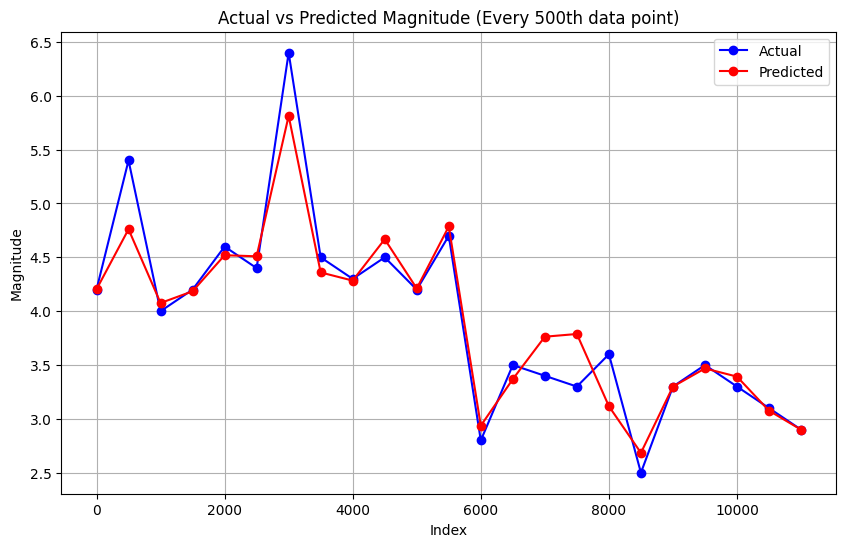

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
predictions = pd.read_csv('composite_lstm_predictions_combined.csv')

# Plotting every nth data point
n = 500 # Change this value as needed
plt.figure(figsize=(10, 6))
plt.plot(predictions.index[::n], predictions['Actual'][::n], marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(predictions.index[::n], predictions['Predicted'][::n], marker='o', linestyle='-', color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.title('Actual vs Predicted Magnitude (Every {}th data point)'.format(n))
plt.legend()
plt.grid(True)
plt.show()
